# Show that to compute radiative heating rates from radiative fluxes, one needs to first compute heating rates on model levels before interpolating to pressure levels

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import helpers as hlp
import sys
sys.path.append("../analysis/")
import cmip6radheating

We illustrate this for the all-sky radiative heating of the BCC-CSM2-MR and the second-to-last year (2013).

In [2]:
model="BCC-CSM2-MR"

In [3]:
flist_rsd, flist_rsu, flist_rld, flist_rlu = cmip6radheating.filelist_allsky_radfluxes(exp="amip", tab="CFmon", mod=model)
ds_rsd = cmip6radheating.load_data(flist_rsd)[0].isel(time=slice(-24,-12))
ds_rsu = cmip6radheating.load_data(flist_rsu)[0].isel(time=slice(-24,-12))
ds_rld = cmip6radheating.load_data(flist_rld)[0].isel(time=slice(-24,-12))
ds_rlu = cmip6radheating.load_data(flist_rlu)[0].isel(time=slice(-24,-12))

ds_asflx = (ds_rsd["rsd"]-ds_rsu["rsu"]+ds_rld["rld"]-ds_rlu["rlu"]).rename("radflx").to_dataset()
ds_asflx = xr.merge([ds_rsd, ds_asflx])

Add pressure and interpolate radiative fluxes to pressure levels.

In [4]:
ds_asflx = cmip6radheating.addpressure2dataset(ds_asflx, model=model, levtype="half")
ds_asflx_int = cmip6radheating.interpolate2pressure(ds_asflx, ["radflx"], cmip6radheating.define_targetlevels())

Now we compute radiative heating from interpolated radiative fluxes.

In [5]:
def compute_heatingrates_plevels(ds):
    # radiative flux
    radflx = ds["radflx"].values
    # pressure levels of the radiative fluxes
    lev = ds.lev.values
    nlev = np.size(lev)
    # compute heating rates
    dradflx = np.diff(radflx, axis=1)
    dlev = np.broadcast_to(np.diff(lev)[None,:,None,None], dradflx.shape)
    hr = -86400 * 9.81/1005 * dradflx/dlev
    # pressure levels of heating rates is in the middle of those of the radiative fluxes
    lev_hr = 0.5*(lev[1:]+lev[0:nlev-1])
    # output dataset with heating rates
    ds_hr = xr.Dataset()
    ds_hr.attrs = ds.attrs
    ds_hr["dTdt"] = xr.DataArray(hr, name="dTdt", dims=("time", "lev", "lat", "lon"), 
                                 coords={"time": ds.time, "lev": lev_hr, "lat": ds.lat, "lon": ds.lon})
    return ds_hr

In [6]:
dTdtas_int = compute_heatingrates_plevels(ds_asflx_int)

For comparison, we load the radiative heating derived from radiative flux divergence on model levels, as well as the radiative heating rate directly output by the model.

In [7]:
dTdtas_flx = xr.open_dataset("/scratch/das/avoigt/cmip6-acre-data/postprocessed/dTdt-as-from-flx_CFmon_"+model+"_amip.zarr", engine="zarr").isel(time=slice(-24,-12))

In [8]:
dTdtas_tntr = xr.open_dataset("/scratch/das/avoigt/cmip6-acre-data/postprocessed/dTdt-as-from-tntr_AERmon_"+model+"_amip.zarr", engine="zarr").isel(time=slice(-24,-12))

### Plotting

In [9]:
clev=np.delete(2.0*np.linspace(-1,1,21),10) # contour levels, remove 0

In [10]:
def make_nice_axes(ax):
    plt.ylim(1000,10)
    plt.yticks([800,600,400,200],["800", "600","400","200"], size=10);
    plt.ylabel("pressure / hPa", loc="top", fontsize=12)
    plt.xlim(-88,88)
    plt.xticks([-60,-30,0,30,60],[" ", " ", " ", " ", " "], size=10, va="top");
    ax.tick_params(direction="in", length=6)

Latitude: -66.7283256028822
Longitude: 67.5


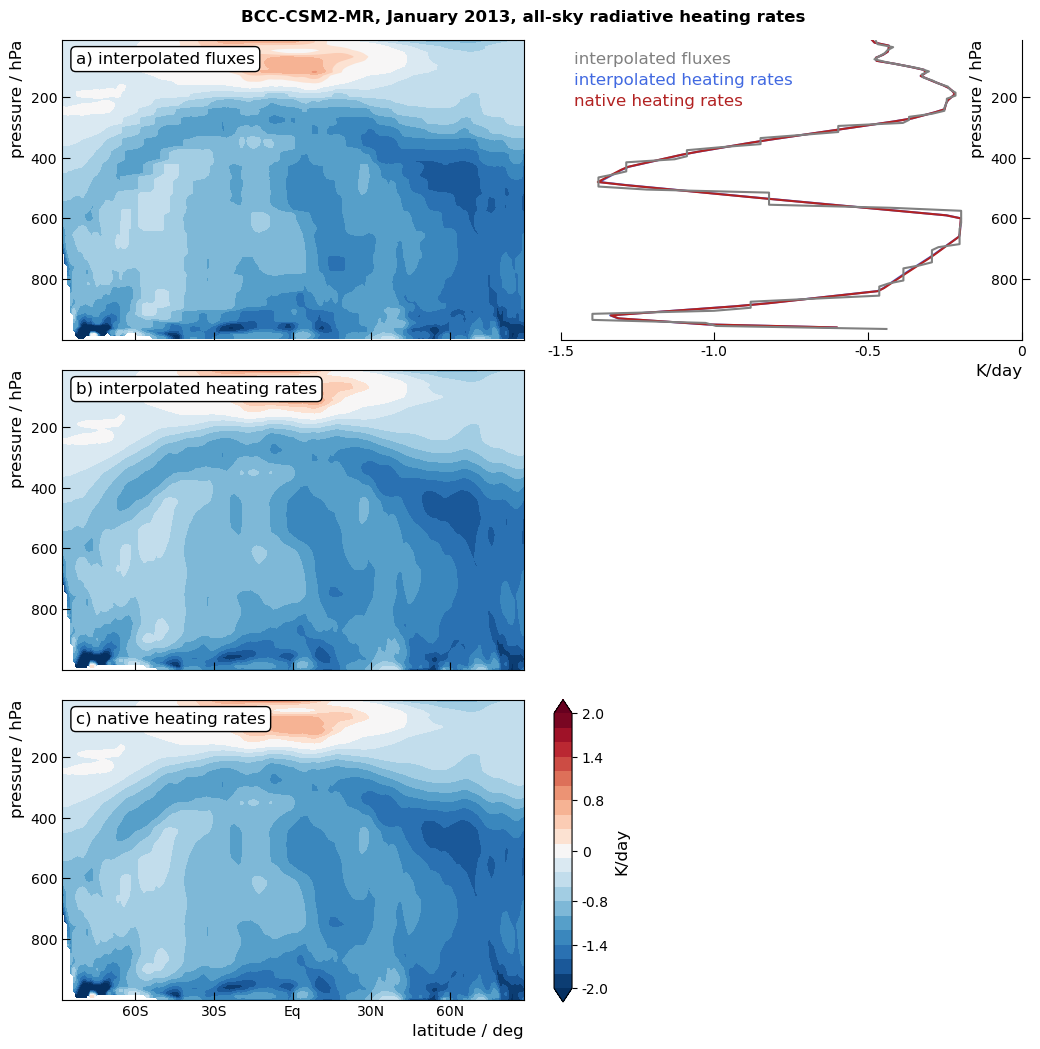

In [11]:
fig=plt.figure(figsize=(6*2,4*3))

ax=plt.subplot(3,2,1)
cnt=plt.contourf(dTdtas_int.lat, dTdtas_int.lev/100, dTdtas_int["dTdt"].isel(time=0).mean("lon"), clev, cmap="RdBu_r", extend="both")
for c in cnt.collections: c.set_edgecolor("face")
make_nice_axes(ax)
ax.text(0.03,0.96, "a) interpolated fluxes", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", 
        size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3")) 

ax.text(1.0,1.1, model+", January 2013, all-sky radiative heating rates", ha="center", va="top", transform=ax.transAxes, backgroundcolor="white", 
        size=12, fontweight="bold") 

ax=plt.subplot(3,2,3)
cnt=plt.contourf(dTdtas_flx.lat, dTdtas_flx.lev/100, dTdtas_flx["dTdt-as-from-flx"].isel(time=0).mean("lon"), clev, cmap="RdBu_r", extend="both")
for c in cnt.collections: c.set_edgecolor("face")
make_nice_axes(ax)
ax.text(0.03,0.96, "b) interpolated heating rates", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", 
        size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))   

ax=plt.subplot(3,2,5)
cnt=plt.contourf(dTdtas_tntr.lat, dTdtas_tntr.lev/100, dTdtas_tntr["dTdt-as-from-tntr"].isel(time=0).mean("lon"), clev, cmap="RdBu_r", extend="both")
for c in cnt.collections: c.set_edgecolor("face")
make_nice_axes(ax)
plt.xlabel("latitude / deg", loc="right", fontsize=12)
plt.xticks([-60,-30,0,30,60],["60S", "30S","Eq","30N","60N"], size=10, va="top");
ax.text(0.03,0.96, "c) native heating rates", ha="left", va="top", transform=ax.transAxes, backgroundcolor="white", 
        size=12, bbox=dict(facecolor="white", edgecolor="k", boxstyle="round,pad=0.3"))   

# plot colorbar
# solution taken and adapted from https://stackoverflow.com/a/62436015
# axes position found manually, to do so use "print(ax)" for above subplots
ax = fig.add_axes([0.51,0.098,0.015, 0.252])
cb = mpl.colorbar.ColorbarBase(ax, orientation="vertical", 
                               cmap="RdBu_r", extend="both", ticks=[-2, -1.4, -0.8, 0.0, 0.8, 1.4, 2.0],
                               label="K/day",
                               boundaries=clev, norm=mpl.colors.Normalize(clev[0], clev[-1]))     
cb.ax.set_yticklabels(["-2.0", "-1.4", "-0.8", "0", "0.8", "1.4", "2.0"])
cb.ax.tick_params(labelsize=10)
cb.set_label(label="K/day", size=12)

ax=plt.subplot(3,2,2)
itime=0
ilat=20
ilon=60
print("Latitude:", dTdtas_tntr.lat[ilat].values)
print("Longitude:", dTdtas_tntr.lon[ilon].values)
# adjust spines
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_position(("data",1000))
ax.spines["left"].set_position(("data",0))
ax.spines["left"].set_color("k")
plt.plot(dTdtas_tntr["dTdt-as-from-tntr"].isel(time=itime,lat=ilat,lon=ilon), dTdtas_tntr.lev/100, color="firebrick")
plt.plot(dTdtas_flx["dTdt-as-from-flx"].isel(time=itime,lat=ilat,lon=ilon), dTdtas_flx.lev/100, color="royalblue", zorder=-100)
plt.plot(dTdtas_int["dTdt"].isel(time=itime,lat=ilat,lon=ilon), dTdtas_int.lev/100, color="gray")
plt.ylim(1000,10)
plt.yticks([800,600,400,200],["800", "600","400","200"], size=10);
plt.xlim(-1.5,0)
plt.xticks([-1.5,-1.0,-0.5,0],["-1.5", "-1.0", "-0.5", "0"], size=10, va="top");
ax.tick_params(direction="in", length=6)
plt.ylabel("pressure / hPa", loc="top", fontsize=12)
plt.xlabel("K/day", loc="right", fontsize=12)
# legend
ax.text(0.03,0.96, "interpolated fluxes", ha="left", va="top", transform=ax.transAxes, color="gray", backgroundcolor="none", size=12) 
ax.text(0.03,0.89, "interpolated heating rates", ha="left", va="top", transform=ax.transAxes, color="royalblue", backgroundcolor="none", size=12) 
ax.text(0.03,0.82, "native heating rates", ha="left", va="top", transform=ax.transAxes, color="firebrick", backgroundcolor="none", size=12) 

hlp.spacing_subplots()

plt.savefig("figures/illustrate_order_of_computation.pdf")